# IQAE

Present notebook reviews the **Iterative Quantum Amplitude Estimation** (**IAQE**) algorithm which was implemented into the modules *iterative_quantum_ae*  within the package **Amplitude Estimation** of library *QQuantLib* (**QQuantLib/AE/iterative_quantum_ae.py**). 

Present notebook and modules are based on the following references:

* *Grinko, D., Gacon, J., Zoufal, C. & Woerner, S.*. Iterative Quantum Amplitude Estimation. npj Quantum Information 7, 2021. https://www.nature.com/articles/s41534-021-00379-1

In [1]:
import sys
sys.path.append("../../")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import qat.lang.AQASM as qlm

In [3]:
%matplotlib inline

In [4]:
#This cell loads the QLM solver.
#QLMaaS == False -> uses PyLinalg
#QLMaaS == True -> try to use LinAlg (for using QPU as CESGA QLM one)
from QQuantLib.utils.qlm_solver import get_qpu
QLMaaS = False
linalg_qpu = get_qpu(QLMaaS)

Using PyLinalg


In [5]:
#See 01_DataLoading_Module_Use for the use of this function
from QQuantLib.utils.data_extracting import get_results
from QQuantLib.utils.utils import bitfield_to_int, load_qn_gate

## 1. Oracle generation

Before doing any amplitude estimation we want to load some data into the quantum circuit, as this step is only auxiliary to see how the algorithm works, we are just going to load a discrete probability distribution. In this case we will have a circuit with $n=3$ qubits which makes a total of $N = 2^n = 8$ states. The discrete probability distribution that we are going to load is:
$$p_d = \dfrac{(0,1,2,3,4,5,6,7)}{0+1+2+3+4+5+6+7+8}.$$


In [ ]:
n = 3
N = 2**n
x = np.arange(N)
probability = x/np.sum(x)

Note that this probability distribution is properly normalised. For loading this probability into the quantum circuit we will use the function *load_probability* from **QQuantLib/DL/data_loading** module. The state that we are going to get is:
    $$|\Psi\rangle = \scriptstyle \dfrac{1}{\sqrt{0+1+2+3+4+5+6+7+8}}\left[\sqrt{0}|0\rangle+\sqrt{1}|1\rangle+\sqrt{2}|2\rangle+\sqrt{3}|3\rangle+\sqrt{4}|4\rangle+\sqrt{5}|5\rangle+\sqrt{6}|6\rangle+\sqrt{7}|7\rangle\right].$$

In [ ]:
from QQuantLib.DL.data_loading import load_probability

In [ ]:
oracle = load_probability(probability)

For more information about loading data into the quantum circuit see the notebook *01_DataLoading_Module_Use*.

In [ ]:
from QQuantLib.AA.amplitude_amplification import grover

In [ ]:
target = [0,0,1]
index = [0,1,2]

In [ ]:
Grover_Gate = grover(
    oracle=oracle, target=target, index=index
)

In [ ]:
%qatdisplay Grover_Gate --svg --depth 2

In [ ]:
def find_next_k(k: int,theta_lower: float,theta_upper: float,flag: bool, r: float = 2):
    """
    This is an implementation of Algorithm 2 from the IQAE paper. This function computes
    the next suitable k.
                                                                                          
    Parameters
    ----------
    k : int
        number of times to apply the grover operator to the quantum circuit
    theta_lower : float
        lower bound for the estimation of the angle
    theta_upper : float
        upper bound for the estimation of the angle
    flag : bool
        flag to keep track of weather we are in the
        upper or lower half pane
    r : float
        ratio of amplifications between consecutive iterations
                                                                                          
    Returns
    ----------
    k : int
        number of times to apply the grover operator to the quantum circuit
    flag : bool
        flag to keep track of weather we are in the
        upper or lower half pane
                                                                                          
    """
    print('Dentro Find Next')
    K_i = 4*k+2
    print('\t k= ', k, 'K_i= ', K_i)
    theta_min = K_i*theta_lower
    theta_max = K_i*theta_upper
    print('\t theta_min= ', theta_min)
    print('\t theta_max= ', theta_max)
    K_max = np.floor(np.pi/(theta_upper-theta_lower))
    print('\t K_max= ', K_max)
    K = K_max-np.mod(K_max-2,4)
    print('\t K= ', K)
    print('\t r*K_i= ', r*K_i)
    while (K>r*K_i):
        q = K/K_i
        print('\t\t K= ',K, 'q = ', q)
        if (np.mod(q*theta_max,2*np.pi)<=np.pi) and (np.mod(q*theta_min,2*np.pi)<=np.pi):
            K_next = K
            flag = True
            k_next = (K_next-2)/4
            print('\t\t flag: ', flag, 'k_next: ', k_next)
            return [int(k_next),flag]
        if (np.mod(q*theta_max,2*np.pi)>=np.pi) and (np.mod(q*theta_min,2*np.pi)>=np.pi):
            K_next = K
            flag = False
            k_next = (K_next-2)/4
            print('\t\t flag: ', flag, 'k_next: ', k_next)
            return [int(k_next),flag]
        print('\t q: ', q, ' no sirve')                                                                            
        K = K-4
        print('\t Nuevo K : ', K)
    return [int(k),flag]

def chebysev_bound(N: int,gamma: float):
    r"""
    Computes the length of the confidence interval for a given number of samples
    N and an accuracy gamma:
                                                                                 
    .. math::
        \epsilon = \dfrac{1}{\sqrt{2N}}\log\left(\dfrac{2}{\gamma}\right)
                                                                                 
    Parameters
    ----------
    N : int
        number of samples
    gamma : float
        accuracy
                                                                                 
    Returns
    ----------
    length of the confidence interval
    """
    return np.sqrt(1/(2*N)*np.log(2/gamma))

def invert_sector(a_min: float ,a_max: float,flag: bool = True):
    r"""
    This function inverts the expression:
                                                                    
    .. math::
        a = \dfrac{1-\cos(\theta)}{2}
                                                                    
    for a pair of bounds (a_min,a_max). The result
    belongs to the domain (0,2\pi)
                                                                    
    Parameters
    ----------
    a_min : float
        lower bound
    a_max : float
        upper bound
    flag : bool
        flag to keep track of weather we are in the
        upper or lower half pane
                                                                    
    Returns
    ----------
    theta_min : float
       lower bound for the associated angle
    theta_max : float
       upper bound for the associated angle
                                                                    
    """
    theta_1 = np.minimum(np.arccos(1-2*a_min),np.arccos(1-2*a_max))
    theta_2 = np.maximum(np.arccos(1-2*a_min),np.arccos(1-2*a_max))
    if (flag):
        theta_min = theta_1
        theta_max = theta_2
    else:
        theta_min = 2*np.pi-theta_2
        theta_max = 2*np.pi-theta_1
                                                                    
    return [theta_min,theta_max]

In [ ]:
def apply(oracle, grover_oracle, m_k, linalg_qpu, nb_shots):
    routine = qlm.QRoutine()
    wires = routine.new_wires(oracle.arity)
    routine.apply(oracle, wires)
    routine.apply(load_qn_gate(grover_oracle, m_k), wires)
    
    results, circuit, q_prog, q_job = get_results(
        routine,
        linalg_qpu=linalg_qpu,
        shots = nb_shots
    )
    return results, circuit, q_prog, q_job


In [ ]:
#Entradas
epsilon = float(0.001)
N = int(100)
alpha = float(0.05)

In [ ]:
#Inicializaciones
i = 0
k = int(0)
flag = True
[theta_l,theta_u] = [0.0,np.pi/2]
print([theta_l,theta_u])
h_k = 0
N_effective = 0

T = int(np.ceil(np.log2(np.pi/(8*epsilon)))+1)
print('T= ',T)

In [ ]:
i = i+1
k_old = k
[k,flag] = find_next_k(
    k=k, theta_lower=theta_l, theta_upper=theta_u, flag=flag
)
print([k,flag])
K = 4*k+2
#Aplicamos el oraculo k veces
results, circuit, q_prog, q_job = apply(oracle, Grover_Gate, k, linalg_qpu, N)
#Obtenemos el resultado de aplicar el oraculo
a = results["Probability"].iloc[bitfield_to_int(target)]
print('a: ',a)
print('k: ', k)
if (k == k_old):
    print('hey')
    h_k = h_k+int(a*N)
    N_effective = N_effective+N
    a = h_k/N_effective 
    i = i-1
else:
    h_k = int(a*N)
    N_effective = N
print('N_effective: ', N_effective)
epsilon_a = chebysev_bound(N_effective,alpha/T)
print('epsilon_a: ', epsilon_a)

In [ ]:
a_max = np.minimum(a+epsilon_a,1.0)
a_min = np.maximum(a-epsilon_a,0.0)
print(a, a_min, a_max)
[theta_min,theta_max] = invert_sector(a_min,a_max,flag)
print([theta_min,theta_max])
theta_l = (2*np.pi*np.floor(K*theta_l/(2*np.pi))+theta_min)/K
theta_u = (2*np.pi*np.floor(K*theta_u/(2*np.pi))+theta_max)/K

In [ ]:
print((theta_l, theta_u))

In [ ]:
i = i+1
k_old = k
print('k= ', k)
[k,flag] = find_next_k(
    k=k, theta_lower=theta_l, theta_upper=theta_u, flag=flag
)
print([k,flag])
K = 4*k+2
#Aplicamos el oraculo k veces
results, circuit, q_prog, q_job = apply(oracle, Grover_Gate, k, linalg_qpu, N)
#Obtenemos el resultado de aplicar el oraculo
a = results["Probability"].iloc[bitfield_to_int(target)]
print('a: ',a)
print('k: ', k)
if (k == k_old):
    print('hey')
    h_k = h_k+int(a*N)
    N_effective = N_effective+N
    a = h_k/N_effective 
    i = i-1
else:
    h_k = int(a*N)
    N_effective = N
print('N_effective: ', N_effective)
epsilon_a = chebysev_bound(N_effective,alpha/T)
print('epsilon_a: ', epsilon_a)

In [ ]:
a_max = np.minimum(a+epsilon_a,1.0)
a_min = np.maximum(a-epsilon_a,0.0)
print(a, a_min, a_max)
[theta_min,theta_max] = invert_sector(a_min,a_max,flag)
print([theta_min,theta_max])
theta_l = (2*np.pi*np.floor(K*theta_l/(2*np.pi))+theta_min)/K
theta_u = (2*np.pi*np.floor(K*theta_u/(2*np.pi))+theta_max)/K


In [ ]:
#Entradas
epsilon = float(0.001)
N = int(100)
alpha = float(0.05)

In [ ]:
#Inicializaciones
i = 0
k = int(0)
flag = True
[theta_l,theta_u] = [0.0,np.pi/2]
print([theta_l,theta_u])
h_k = 0
N_effective = 0

T = int(np.ceil(np.log2(np.pi/(8*epsilon)))+1)
print('T= ',T)

In [ ]:
List_theta_l = []
List_theta_u = []
List_k = []
List_eps = []

for i in range(15):
    print('[theta_l, theta_u]= ', [theta_l,theta_u])
    List_theta_l.append(theta_l)
    List_theta_u.append(theta_u)
    i = i+1
    k_old = k
    [k,flag] = find_next_k(
        k=k, theta_lower=theta_l, theta_upper=theta_u, flag=flag
    )
    print([k,flag])
    K = 4*k+2
    #Aplicamos el oraculo k veces
    results, circuit, q_prog, q_job = apply(oracle, Grover_Gate, k, linalg_qpu, N)
    List_k.append(k)
    #Obtenemos el resultado de aplicar el oraculo
    a = results["Probability"].iloc[bitfield_to_int(target)]
    print('a: ',a)
    print('k: ', k)
    if (k == k_old):
        print('hey')
        h_k = h_k+int(a*N)
        N_effective = N_effective+N
        a = h_k/N_effective 
        i = i-1
    else:
        h_k = int(a*N)
        N_effective = N
    print('N_effective: ', N_effective)
    epsilon_a = chebysev_bound(N_effective,alpha/T)
    print('epsilon_a: ', epsilon_a)
    List_eps.append(epsilon_a)
    
    a_max = np.minimum(a+epsilon_a,1.0)
    a_min = np.maximum(a-epsilon_a,0.0)
    print('a_min= ', a_min, 'a_max= ', a_max)
    [theta_min,theta_max] = invert_sector(a_min,a_max,flag)
    print('[theta_min, theta_max]= ', [theta_min,theta_max])
    theta_l = (2*np.pi*np.floor(K*theta_l/(2*np.pi))+theta_min)/K
    theta_u = (2*np.pi*np.floor(K*theta_u/(2*np.pi))+theta_max)/K
List_theta_l.append(theta_l)
List_theta_u.append(theta_u)

In [ ]:
np.log(2*np.log(np.pi/(8.0*epsilon)))

In [24]:
def CalculateStaff(epsilon, alfa=0.05, N=100):
    T_up = np.ceil(np.log2(np.pi/(8*epsilon)))
    print(T_up)
    T = np.log(2*T_up/alfa)
    return np.sqrt(T/(2*N))

In [27]:
eps = np.array([i/1000 for i in range(100)])[1:]

[9. 8. 8. 7. 7. 7. 6. 6. 6. 6. 6. 6. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 2.]
[9. 8. 8. 7. 7. 7. 6. 6. 6. 6. 6. 6. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 2.]


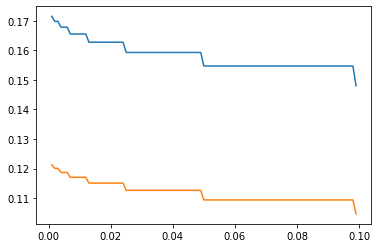

In [30]:
plt.plot(eps,CalculateStaff(eps))
plt.plot(eps,CalculateStaff(eps, N=200))

In [29]:
np.ceil(5.29535232)

6.0

## 2. IQAE class.

The problem of amplitude estimation is the following. Given an oracle:

$$\mathcal{0}|0\rangle = |\Psi\rangle = \sqrt{a}|\Psi_0\rangle +\sqrt{1-a}|\Psi_1\rangle,$$

where $|\Psi_0\rangle$ and $|\Psi_1\rangle$ are orthogonal states, we want to estimate $a$.

We have implemented and python class called **IQAE** into the **QQuantLib/AE/iterative_quantum_ae** module that allows us to use the **IQAE** algorithm.

### Definition of the problem

In [ ]:
#import the class
from QQuantLib.AE.iterative_quantum_ae import IQAE

For showing how our class and the algorithm works, we will define the following amplitude estimation problem:
$$
    \begin{array}{l}
    &\mathcal{O}\longrightarrow \mathcal{P}.\\
    & |\Psi\rangle \longrightarrow \scriptstyle \dfrac{1}{\sqrt{0+1+2+3+4+5+6+7+8}}\left[\sqrt{0}|0\rangle+\sqrt{1}|1\rangle+\sqrt{2}|2\rangle+\sqrt{3}|3\rangle+\sqrt{4}|4\rangle+\sqrt{5}|5\rangle+\sqrt{6}|6\rangle+\sqrt{7}|7\rangle\right].\\
    & \sqrt{a}|\Psi_0\rangle \longrightarrow \dfrac{\sqrt{1}}{\sqrt{0+1+2+3+4+5+6+7+8}}|1\rangle.\\
    & \sqrt{1-a}|\Psi_1\rangle \longrightarrow \scriptstyle \dfrac{1}{\sqrt{0+1+2+3+4+5+6+7+8}}\left[\sqrt{0}|0\rangle+\sqrt{2}|2\rangle+\sqrt{3}|3\rangle+\sqrt{4}|4\rangle+\sqrt{5}|5\rangle+\sqrt{6}|6\rangle+\sqrt{7}|7\rangle\right].\\
    \end{array}
$$
The target state, in this case is $|1\rangle$. It's binary representation is $001$. This has to be passed to the target variable as a list. Moreover we have to provide the list of qubits where we are acting, in this case is just $[0,1,2]$, the whole register.

In [ ]:
target = [0,0,1]
index = [0,1,2]
a = probability[bitfield_to_int(target)]

iqae = IQAE(oracle,target = target,index = [0,1,2])

### Execution

The only relevant methods for the end user are *run* and *display_information*. First, the method *run* returns an upper and lower bound estimates of the probability $a$: $(a_{\min},a_{\max})$. The output is in the form of a list. The function has three inputs:
* epsilon: the precision. Ensures that the width of the interval is, at most, $2\epsilon$.
* N: the number of shots on each iteration of the algorithm.
* alpha: the accuracy. Ensures that the probability of $a$ not laying within the given interval is, at most, $\alpha$.

In [ ]:
epsilon = 0.001
N = 100
alpha = 0.05
bounds = iqae.run(epsilon = epsilon,N = N, alpha = alpha)

Now we will check weather the real value of $a$ lays within the bounds. Most of the times (at least with 95% in this case) it will be the case.

In [ ]:
print("Bounds: ",bounds)
print("Real value: ",a)

In [ ]:
if (a>=bounds[0])&(a<=bounds[1]):
    print("Correct")
else:
    print("Incorrect")

Second, the method *display_information* displays some informamtion of the inner workings of the method. The function has the same three inputs as in the previous case.

In [ ]:
iqae.display_information(epsilon = epsilon,N = N, alpha = alpha)

## 3. RQAE class

The new problem of amplitude estimation is the following. Given an oracle:

$$\mathcal{0}|0\rangle = |\Psi\rangle = a|\Psi_0\rangle +\sqrt{1-a^2}|\Psi_1\rangle,$$

where $|\Psi_0\rangle$ and $|\Psi_1\rangle$ are orthogonal states, we want to estimate the real parameter $a$. Note that there is a slight difference with the previous case, now $a$ is not within a square root. Moreover, it is a real parameter, this means that it can take values in the domain $[-1,1]$.

We have implemented and python class called **RQAE** into the **QQuantLib/AE/real_quantum_ae** module that allows us to use the **RQAE** algorithm.

### Definition of the problem

In [ ]:
#import the class
from QQuantLib.AE.real_quantum_ae import RQAE

For showing how our class and the algorithm works, we will define the following amplitude estimation problem:
$$
    \begin{array}{l}
    &\mathcal{O}\longrightarrow \mathcal{P}.\\
    & |\Psi\rangle \longrightarrow \scriptstyle \dfrac{1}{\sqrt{0+1+2+3+4+5+6+7+8}}\left[\sqrt{0}|0\rangle+\sqrt{1}|1\rangle+\sqrt{2}|2\rangle+\sqrt{3}|3\rangle+\sqrt{4}|4\rangle+\sqrt{5}|5\rangle+\sqrt{6}|6\rangle+\sqrt{7}|7\rangle\right].\\
    & a|\Psi_0\rangle \longrightarrow \dfrac{\sqrt{1}}{\sqrt{0+1+2+3+4+5+6+7+8}}|1\rangle.\\
    & \sqrt{1-a^2}|\Psi_1\rangle \longrightarrow \scriptstyle \dfrac{1}{\sqrt{0+1+2+3+4+5+6+7+8}}\left[\sqrt{0}|0\rangle+\sqrt{2}|2\rangle+\sqrt{3}|3\rangle+\sqrt{4}|4\rangle+\sqrt{5}|5\rangle+\sqrt{6}|6\rangle+\sqrt{7}|7\rangle\right].\\
    \end{array}
$$
The target state, in this case is $|1\rangle$. It's binary representation is $001$. This has to be passed to the target variable as a list. Moreover we have to provide the list of qubits where we are acting, in this case is just $[0,1,2]$, the whole register.

In [ ]:
target = [0,0,1]
index = [0,1,2]
a = np.sqrt(probability[bitfield_to_int(target)])

rqae = RQAE(oracle,target = [0,0,1],index = [0,1,2])

Note again that a is now defined as an amplitude, that is why we take it's square root.

### Execution

The only relevant methods for the end user are *run* and *display_information*. First, the method *run* returns an upper and lower bound estimates of the amplitude $a$: $(a_{\min},a_{\max})$. The output is in the form of a list. The function has three inputs:
* q: the ratio of amplifications between iterations. It's value has to be bigger than one. Rule of thumbs $q=2$.
* epsilon: the precision. Ensures that the width of the interval is, at most, $2\epsilon$.
* alpha: the accuracy. Ensures that the probability of $a$ not laying within the given interval is, at most, $\alpha$.

In [ ]:
q = 2
epsilon = 0.001
gamma = 0.05
bounds = rqae.run(q = q,epsilon = epsilon, gamma = gamma)

Now we will check weather the real value of $a$ lays within the bounds. Most of the times (at least with 95% in this case) it will be the case.

In [ ]:
print("Bounds: ",bounds)
print("Real value: ",a)

In [ ]:
if (a>=bounds[0])&(a<=bounds[1]):
    print("Correct")
else:
    print("Incorrect")

Second, the method *display_information* displays some informamtion of the inner workings of the method. The function has the same three inputs as in the previous case.

In [ ]:
rqae.display_information(q = q,epsilon = epsilon, gamma = gamma)